In [1]:
using Gridap, Gridap.Geometry, Gridap.Fields
using Gmsh, GridapGmsh
using GLMakie, DelimitedFiles, Interpolations
using LinearAlgebra, SparseArrays, KrylovKit
using ChainRulesCore, Zygote
using PartitionedArrays
using NLopt
using GridapMakie

import Gridap.CellData: Interpolable
import ChainRulesCore: rrule
import Gmsh: gmsh


main_path = "/Users/jayyao/Documents/Research/RamanInFluid/"
include(main_path*"Materials/Materials.jl")
include(main_path*"Module/Mesh_Periodic_Cir.jl")
include(main_path*"Module/Helper.jl")
include(main_path*"Module/GridapFE.jl")
include(main_path*"Module/Control.jl")
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")

g0_p_optimize (generic function with 3 methods)

In [2]:
hr = 0          # Height of Raman molecule
# Geometry parameters of the mesh
L = 150           # Length of the normal region
hair = 500 + hr       # Height of the air region
hs = 300 + hr         # Height of the source location in air
ht = 200 + hr         # Height of the target location in air
hd = 200          # Height of design domain
rd = 10           # Center radius
hsub = 100        # Height of substrate domain below design domain
dpml = 300        # Thickness of the PML
hrd = [0, hd/2]
# Characteristic length (controls the resolution, smaller the finer)
resol = 30        # Number of points per wavelength
l1 = L/resol      # Air
l2 = l1/2.0       # Design domain
l3 = l1           # PML

meshfile = "geometry.msh"
geo_param = PeriodicCirGeometry(L, hair, hs, ht, hd, rd, hsub, dpml, l1, l2, l3)
MeshGenerator(geo_param, meshfile)
# run(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/geometry.msh /Users/jayyao/Documents/Research/RamanInFluid/`)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (L

In [3]:
############  Optimization parameters #############
flag_f = true       # Turn on filter
flag_t = true       # Turn on threshold

# Filter and threshold paramters
r = [0.02 * L, 0.02 * L]  # Filter radius
β = 80.0                  # β∈[1,∞], threshold sharpness
η = 0.5                   # η∈[0,1], threshold center

α = 0.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

# Number of subspace
K = 20

# Amplify g for NLopt
Amp = 1

# Sum over kx
nkx = 30
nparts = nkx / 2

Bp = false          # Matrix B depend on parameters?
pv = 1

# Foundary constraint parameters
c = 0#resol^4
lw = r[1]
ls = r[1]
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])

control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f)



Info    : Reading 'geometry.msh'...
Info    : 51 entities
Info    : 16789 nodes
Info    : 33076 elements
Info    : Done reading 'geometry.msh'


GridapParameters(UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), 11266, BodyFittedTriangulation(), Measure(), Measure(), Measure(), Measure(), Measure(), Measure(), GenericCellField(), Int8[8, 8, 8, 8, 8, 8, 8, 8, 8, 8  …  11, 11, 11, 11, 11, 11, 11, 11, 11, 11], 7)

In [4]:

material = "Ag"
n_λ, k_λ = RefractiveIndex(material,main_path,true)
λ1 = 532
λ2 = 549
nm1 = n_λ(λ1) + 1im * k_λ(λ1)
nm2 = n_λ(λ2) + 1im * k_λ(λ2)
nf = sqrt(1.77)
μ = 1
R = 1e-10
LHp=[Inf, hair + hd]  # Start of PML for x,y > 0
LHn=[Inf, hsub]       # Start of PML for x,y < 0


ω1 = 2 * π / λ1
phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
ω2 = 2 * π / λ2
phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)



PhysicalParameters(0.011444781980290685, 1.3304134695650072, 0.05988059701492538 + 3.5892477611940294im, 0.05988059701492538 + 3.5892477611940294im, 1.0, 1.0e-10, 300.0, [Inf, 700.0], [Inf, 100.0], 200.0)

In [ ]:
p_init = ones(gridap.np) * 0.5 + rand(gridap.np) * 1e-2
β_list = [5.0, 10.0, 20.0, 30.0, 40.0, 60.0, 80.0]
# β_list = [80.0, 80.0, 80.0, 80.0, 80.0]

g_opt = 0
for bi = 1 : 7
    β = β_list[bi]
    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

    if bi == 1
        g_opt, p_opt = g0_p_optimize(p_init, 1e-12, 200; phys1, phys2, control, gridap)
    
    else
        g_opt, p_opt = g0_p_optimize([], 1e-12, 200; phys1, phys2, control, gridap)
    end
    if isfile("p_opt.value.txt")
        run(`rm p_opt_value.txt`)
    end
    open("p_opt_value.txt", "w") do iop
        for i = 1 : length(p_opt)
            p_temp = p_opt[i]
            write(iop, "$p_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt

In [ ]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    #p_max = readdlm("cloud/task5/p_opt_value.txt", Float64)
    p_max = readdlm("p_opt_value.txt", Float64)
    p0 = p_max[:]
else
    p0 = zeros(gridap.np)
end

kb = 0
pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
o_vec = VectorO(1, 1; gridap)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
save("Results/shape.png", fig)
fig

In [ ]:
maxv = maximum(abs.(u1_vec))/10
#fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-maxv, maxv))
fig, ax, plt = plot(gridap.Ω, abs(u1h), colormap = :hot)
Colorbar(fig[1,2], plt)
ax.title = "Design Shape"
#ax.aspect = AxisAspect(L/(phys1.LHp[2]+phys1.LHn[2]))
#limits!(ax, -L/2, L/2, -phys1.LHn[2], phys1.LHp[2])
ax.aspect = AxisAspect(L/(hd+hr))
limits!(ax, -L/2, L/2, 0, hd+hr)
fig

In [ ]:
p0 = rand(gridap.np)
δp = rand(gridap.np)*1e-8
grad = zeros(gridap.np)

kb = 0.0 * ω1
g0 = g0_p(p0, grad; kb, phys1, phys2, control, gridap)
g1 = g0_p(p0+δp, []; kb, phys1, phys2, control, gridap)
g1-g0, grad'*δp

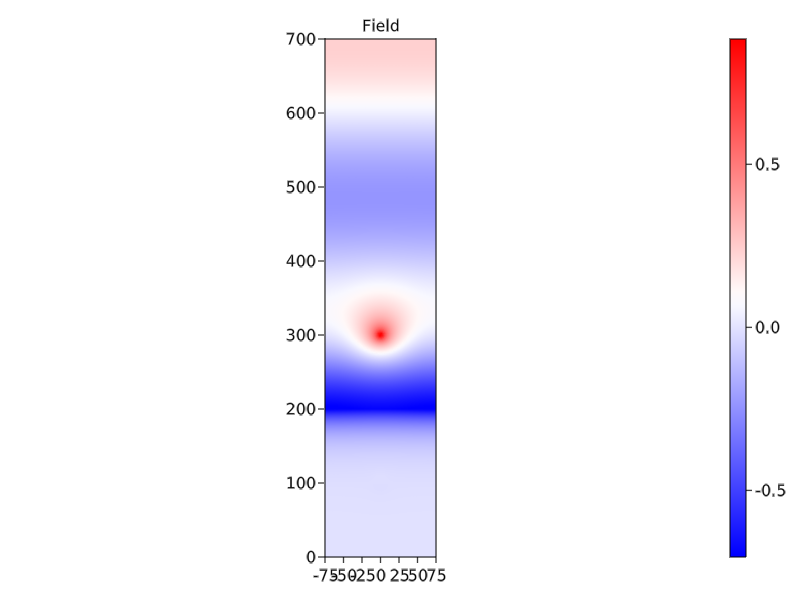

In [7]:
kb = 0
h_point = hd + 100
p0 = ones(gridap.np)
pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
b1_vec = assemble_vector(v->(∫(v*(x->GaussianD(x, [0, h_point], [2,2])))gridap.dΩ), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)


fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd+hair))
ax.title = "Field"
limits!(ax, -L/2, L/2, 0, hd+hair)
#save("Results/shape.png", fig)
fig

In [10]:
function p_bowtie(x, d, h, L, hd)
    dx = abs(x[1]) - d / 2 
    dy = abs(x[2] - hd / 2)
    bowtie = 0
    if dx >= 0 && dy <= h / (L - d) * dx
        bowtie = 1
    end
    return bowtie
end

function power_single_hr(hr)
    # Geometry parameters of the mesh
    L = 150           # Length of the normal region
    hair = 500 + hr       # Height of the air region
    hs = 300 + hr         # Height of the source location in air
    ht = 200 + hr         # Height of the target location in air
    hd = 100          # Height of design domain
    rd = 10           # Center radius
    hsub = 100        # Height of substrate domain below design domain
    dpml = 300        # Thickness of the PML
    hrd = [0, hd/2]
    # Characteristic length (controls the resolution, smaller the finer)
    resol = 30        # Number of points per wavelength
    l1 = L/resol      # Air
    l2 = l1/5.0       # Design domain
    l3 = l1           # PML

    meshfile = "geometry.msh"
    geo_param = PeriodicCirGeometry(L, hair, hs, ht, hd, rd, hsub, dpml, l1, l2, l3)
    MeshGenerator(geo_param, meshfile)
    
    ############  Optimization parameters #############
    flag_f = true       # Turn on filter
    flag_t = true       # Turn on threshold

    # Filter and threshold paramters
    r = [0.02 * L, 0.02 * L]  # Filter radius
    β = 80.0                  # β∈[1,∞], threshold sharpness
    η = 0.5                   # η∈[0,1], threshold center

    α = 0.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

    # Number of subspace
    K = 20

    # Amplify g for NLopt
    Amp = 1

    # Sum over kx
    nkx = 30
    nparts = nkx / 2

    Bp = false          # Matrix B depend on parameters?
    pv = 1

    # Foundary constraint parameters
    c = 0#resol^4
    lw = r[1]
    ls = r[1]
    ηe = fηe(lw / r[1])
    ηd = fηd(lw / r[1])

    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

    gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f)

    
    material = "Ag"
    n_λ, k_λ = RefractiveIndex(material,main_path,true)
    λ1 = 532
    λ2 = 549
    nm1 = n_λ(λ1) + 1im * k_λ(λ1)
    nm2 = n_λ(λ2) + 1im * k_λ(λ2)
    nf = sqrt(1.77)
    μ = 1
    R = 1e-10
    LHp=[Inf, hair + hd]  # Start of PML for x,y > 0
    LHn=[Inf, hsub]       # Start of PML for x,y < 0


    ω1 = 2 * π / λ1
    phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
    ω2 = 2 * π / λ2
    phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)

    kb = 0
    h_point = hd + hr
    # p0 = rand(gridap.np)

    kb = 0
    d = 20
    h = 100
    bowtie_temp(v) = ∫(v * x->p_bowtie(x, d, h, L, hd))gridap.dΩ
    pc_vec = assemble_vector(bowtie_temp, gridap.FE_P)
    p_init = p_extract(pc_vec; gridap)
    p_init[p_init .< 0.1] .= 0
    p_init[p_init .> 0.1] .= 1
    
    pf_vec = pf_p0(p_init; control, gridap)
    pfh = FEFunction(gridap.FE_Pf, pf_vec)
    pth = (pf -> Threshold(pf; control)) ∘ pfh
    A1_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
#     b1_vec = assemble_vector(v->(∫(v*(x->GaussianD(x, [0, h_point], [2,2])))gridap.dΩ), gridap.FE_V)
#     u1_vec = A1_mat \ b1_vec
    

#     O_mat = MatrixOl(phys2.ω, phys2.nf^2; gridap)
    O_vec = VectorO(1, 1; gridap)
    e_vec = A1_mat'\O_vec
    
    B1_mat = assemble_matrix(gridap.FE_U, gridap.FE_V) do u, v
        ∫((x->fr(x, λ2/nf/4, hd + hr - λ2/nf/4)) * (∇(v) ⋅ ∇(u)))gridap.dΩ
    end
    B2_mat = assemble_matrix(gridap.FE_U, gridap.FE_V) do u, v
        ∫((x->fr(x, λ2/nf/2, hd + hr - λ2/nf/2)) * (∇(v) ⋅ ∇(u)))gridap.dΩ
    end
    
    # return real(u1_vec'*O_mat*u1_vec), abs2(u1_vec'*O_vec)
    return real(e_vec'*B1_mat*e_vec), real(e_vec'*B2_mat*e_vec)
end

power_single_hr (generic function with 1 method)

In [11]:
Ng = 200
p_list = zeros(Ng)
pm_list = zeros(Ng)
h_list = zeros(Ng)

for hi = 1:Ng
    print(hi,"\n")
    λf = 549/sqrt(1.77)
    hr = (hi+40) * λf / 2 / 20
    h_list[hi] = hr/λf
    power1, power2 = power_single_hr(hr)
    p_list[hi] = power1
    pm_list[hi] = power2
    # pm_list[hi] = pm
end



1
Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : 

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Excessive output truncated after 524923 bytes.

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

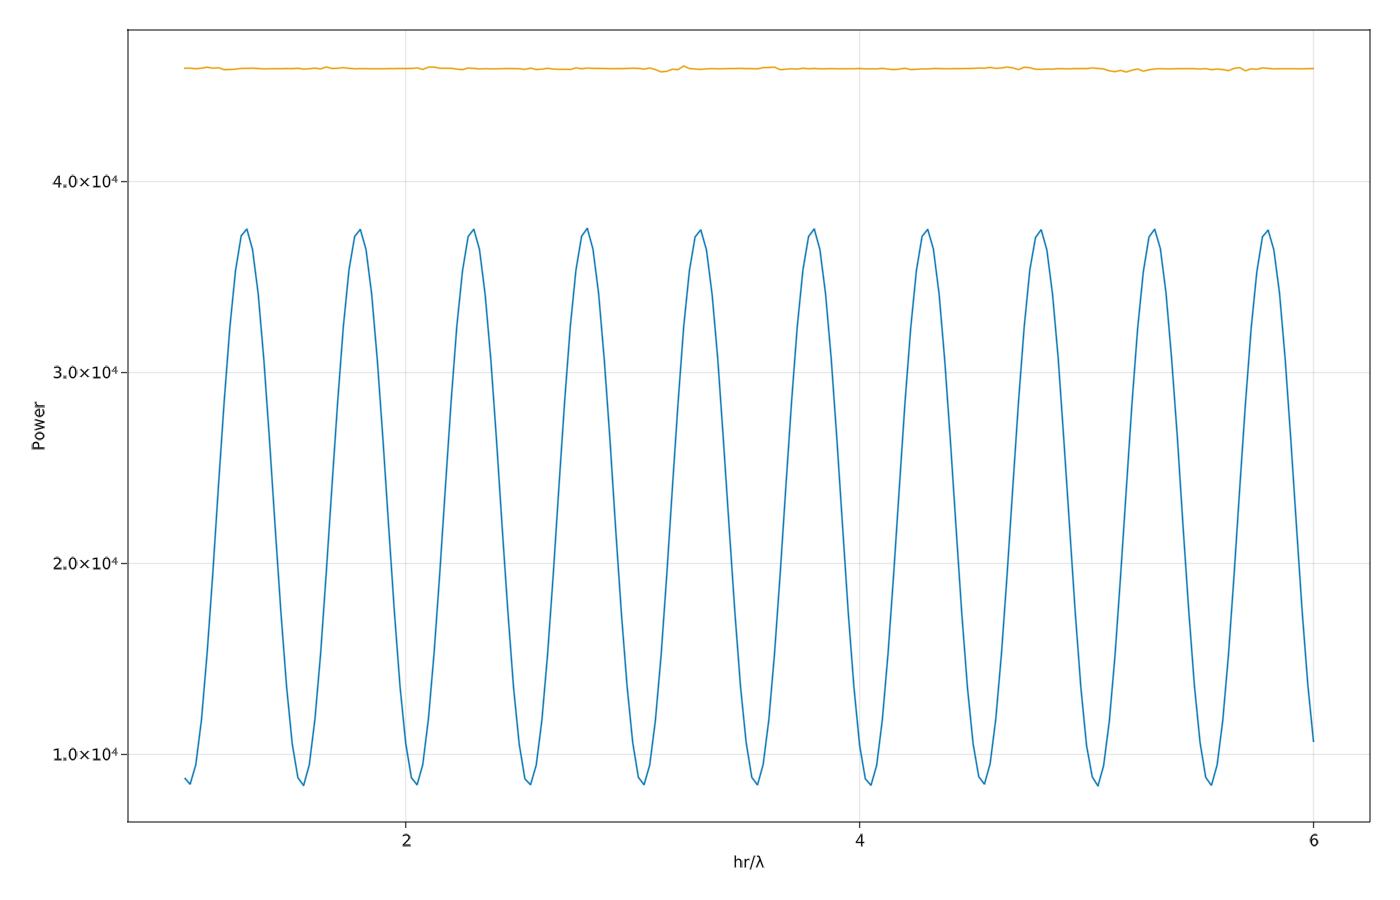

In [12]:
scene, layout = layoutscene(resolution=(1400,900))
ax = layout[1,1]=Axis(scene)
ms = 10
lin1 = lines!(ax,h_list,p_list)
# lin2 = lines!(ax,h_list,range(1,length(h_list),step=1).*g0_list)
lin2 = lines!(ax,h_list,pm_list)

#lin2 = scatter!(ax,range(1,12,step=1),g_r10,markersize=10)
#lin3 = lines!(ax,range(1,12,step=1),gr_r5.+1e-9)
#ax.yscale = log10
ax.xlabel="hr/λ"
ax.ylabel="Power"
#ax.title="Eigenvalue distribution"

# Legend(layout[1,1],[lin1, lin2],["Initial", "Optimized"])
# axislegend(ax, [lin1, lin2, lin3],["All","Far field","Difference"], position = :rt,
#     orientation = :vertical)
# save("Results/EigenValDistributionIO.png",scene)
scene